# Import modules and read data

In [1]:
# Import modules
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation

In [2]:
# Specify data path
input_path = '../data/six_pipes'

# Get model components
superjunctions = pd.read_csv(f'{input_path}/superjunctions.csv')
superlinks = pd.read_csv(f'{input_path}/superlinks.csv')
junctions = pd.read_csv(f'{input_path}/junctions.csv')
links = pd.read_csv(f'{input_path}/links.csv')

# Read input data
Q_in = pd.read_csv(f'{input_path}/flow_input.csv', index_col=0)
H_bc = pd.read_csv(f'{input_path}/boundary_stage.csv', index_col=0)

# Create and run hydraulic model

In [3]:
# Instantiate superlink model
superlink = SuperLink(superlinks, superjunctions, links, junctions, min_depth=0.0)    

In [4]:
# Set constant timestep
dt = 30

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, H_bc=H_bc) as simulation:
    # While simulation time has not expired...
    while simulation.t <= simulation.t_end:
        # Step model forward in time
        simulation.step(dt=dt, num_iter=1)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()

[==================================================] 100.0% [1.25 s]

# Plot results

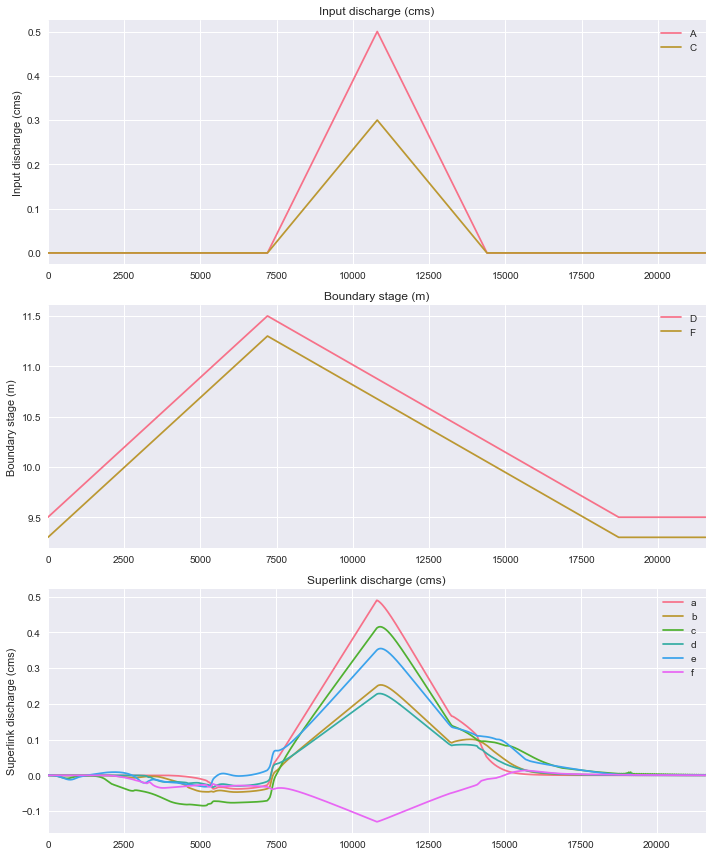

In [5]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl')
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(3, figsize=(10, 12))

# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states.Q_uk + simulation.states.Q_dk) / 2

# Plot results
simulation.Q_in[['A', 'C']].plot(ax=ax[0], title='Input discharge (cms)')
simulation.H_bc[['D', 'F']].plot(ax=ax[1], title='Boundary stage (m)')
simulation.states.Q_k.plot(ax=ax[2], title='Superlink discharge (cms)')

# Configure plots
ax[0].set_ylabel('Input discharge (cms)')
ax[1].set_ylabel('Boundary stage (m)')
ax[2].set_ylabel('Superlink discharge (cms)')
plt.tight_layout()